In [1]:
from utils import Data

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

/ihome/hosmanbeyoglu/kor11/.virtualenvs/deepbio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
import pandas as pd 
import os
from scipy.stats import ttest_ind
import argparse
import numpy as np
from tqdm.notebook import tqdm

In [5]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") ##This is bad but temporary
import yaml 
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)
    
tf_gene = np.load('tf_gene.npy')
    
parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = tf_gene
    

dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

daata = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = daata['idx2can']


models = []
for m in Path('/ix/hosmanbeyoglu/kor11/output').iterdir():
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    models.append(model)

In [6]:
def generateTFactivity(tf, idx2can, tmr, cans, tf_name):
    # generate the TF activity matrix
    df_TF = pd.DataFrame(data = tf, columns = tf_name, index = tmr)
    can_names = [idx2can[idx] for idx in cans]
    df_TF["cancer_type"] = can_names
    return(df_TF)

In [10]:
from tqdm.notebook import tqdm

In [11]:
tf_2d = []
pathway_2d = []

for m in tqdm(models[:4]):
    preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt  = model.forward(torch.tensor(dataset['sga']), torch.from_numpy(dataset['can']))
    tf_2d.append(tf.detach().numpy())
    pathway = model.forward(torch.tensor(dataset['sga']), torch.from_numpy(dataset['can']), pathways=True)
    pathway_2d.append(pathway.detach().numpy())

    del preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt, pathway

Exception ignored in: <function tqdm.__del__ at 0x7f5bba058950>
Traceback (most recent call last):
  File "/ihome/hosmanbeyoglu/kor11/.virtualenvs/deepbio/lib/python3.7/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/ihome/hosmanbeyoglu/kor11/.virtualenvs/deepbio/lib/python3.7/site-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [7]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
np.array(tf_2d).shape, np.array(pathway_2d).shape

((4, 4642, 320), (4, 4642, 50))

In [19]:
tf_2d = np.array(tf_2d).mean(0)
pathway_2d = np.array(pathway_2d).mean(0)

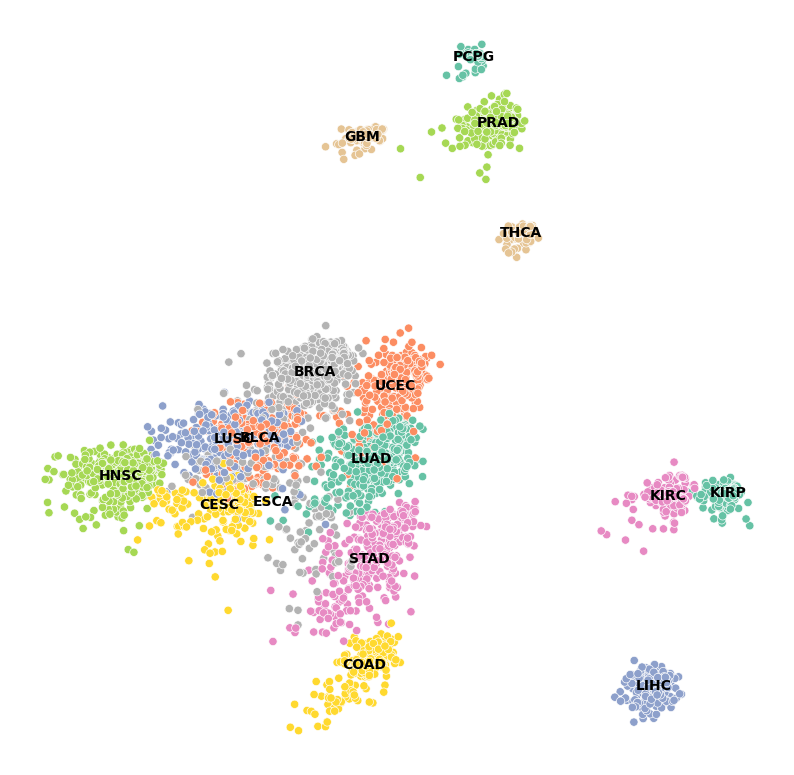

In [32]:
pca = PCA(n_components=2)
x = pathway_2d

d = data_csv.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)

pca.fit(x)
pca.explained_variance_ratio_
dff = pd.DataFrame(pca.transform(x))
dff.columns = ['PC1', 'PC2']
dff['cancer'] = d.loc[dataset['tmr']]['type'].values


fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

sns.scatterplot(data=dff, x='PC1', y='PC2', hue='cancer', ax=ax, palette='Set2')

for r in dff.groupby('cancer').mean().iterrows():
    label = r[0]
    if label != 'BRCA' or label == 'BRCA':
        ax.annotate(r[0], 
                (r[1].PC1, r[1].PC2),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, weight='bold',)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.get_legend().remove()
plt.axis('off')
# plt.title('Pathways PCA Decomposition')
plt.savefig('pathways.svg', format='svg', dpi=1200)
plt.show()

In [38]:
run = list()

for d in tqdm(list(Path('/ix/hosmanbeyoglu/kor11/CITRUS_PKL').glob('*.pkl'))):
    dataset = pickle.load( open(d, "rb") )
    run.append(dataset) 
    
tfs = list()
for i in range(len(run)):
    tfs.append(run[i]["hid_tmr"])

  0%|          | 0/13 [00:00<?, ?it/s]

In [39]:
tf_ensemble = 0
for i in range(len(run)):
    tf_ensemble += tfs[i]
    
tf_ensemble = tf_ensemble/len(run)

df_tf = generateTFactivity(tf_ensemble, daata["idx2can"],daata["tmr"], daata["can"], daata["tf_name"])


In [40]:
from scipy.stats import ttest_ind as ttest

In [41]:
df = pd.DataFrame(np.column_stack([daata['tmr'], daata['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(daata['idx2can'])

def split_mutants(cancer, gene):    
    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'
    
    dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    scna = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 1)]
    sm_scna = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 1)]
    
    return wt.index.values, sm.index.values, scna.index.values, sm_scna.index.values

In [42]:
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

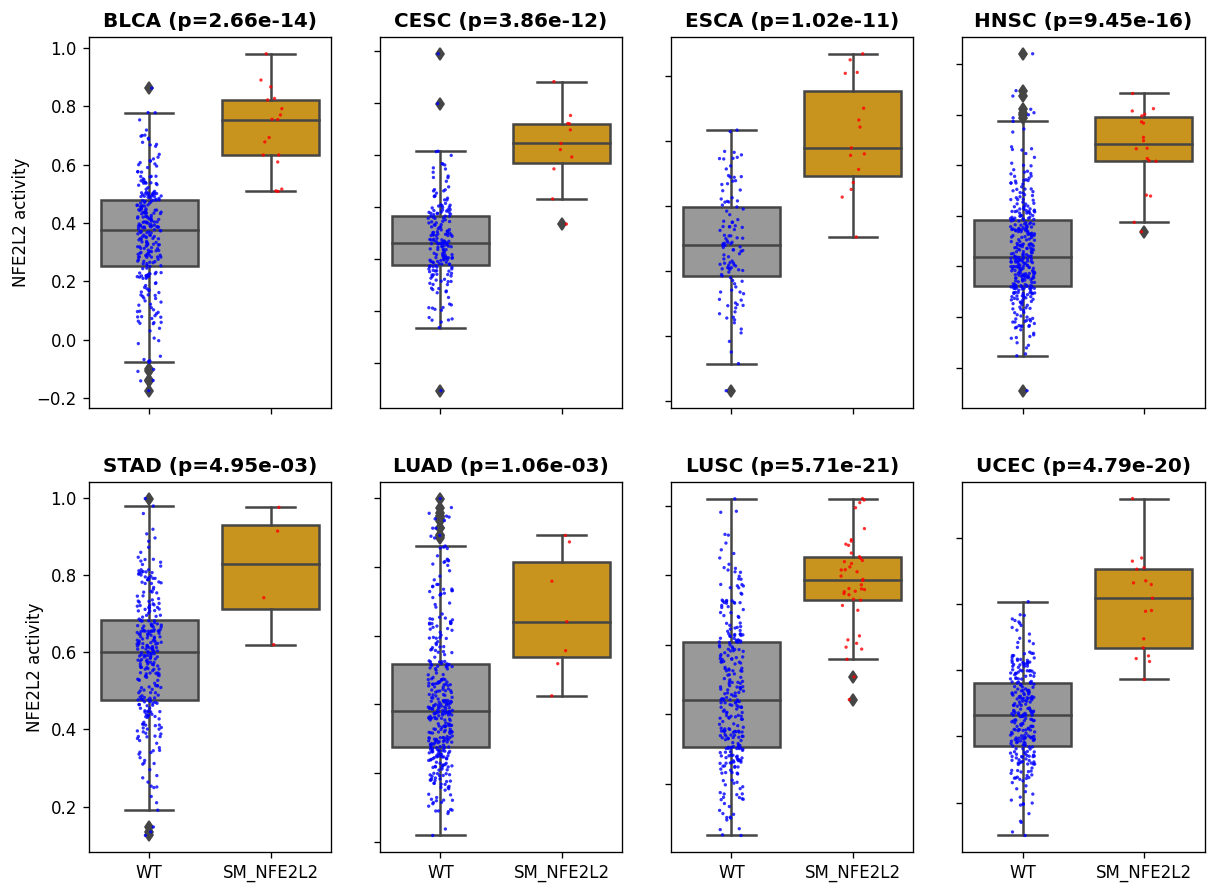

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'NFE2L2'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

for ax in axes.flat:
    ax.label_outer()
plt.show()

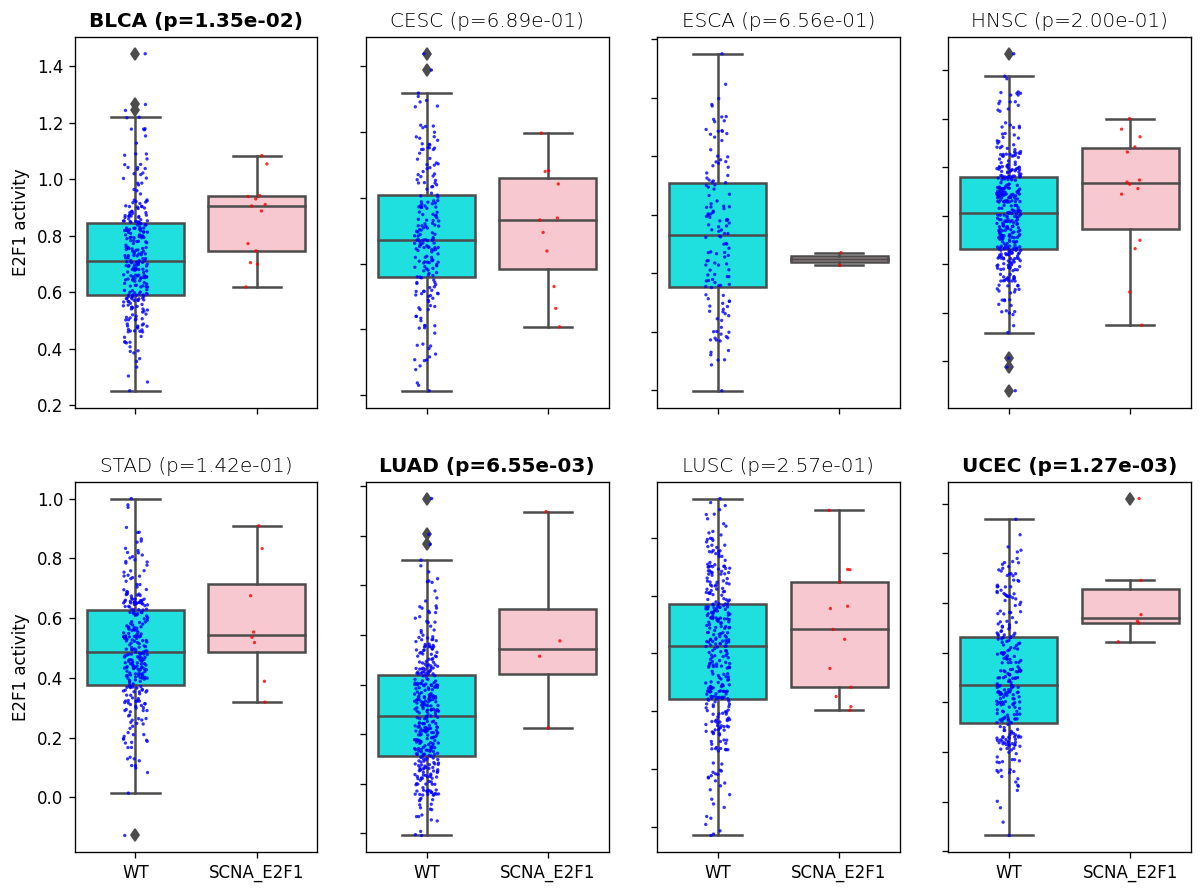

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'E2F1'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, scna, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(wt).union(set(scna))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SCNA_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SCNA_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()

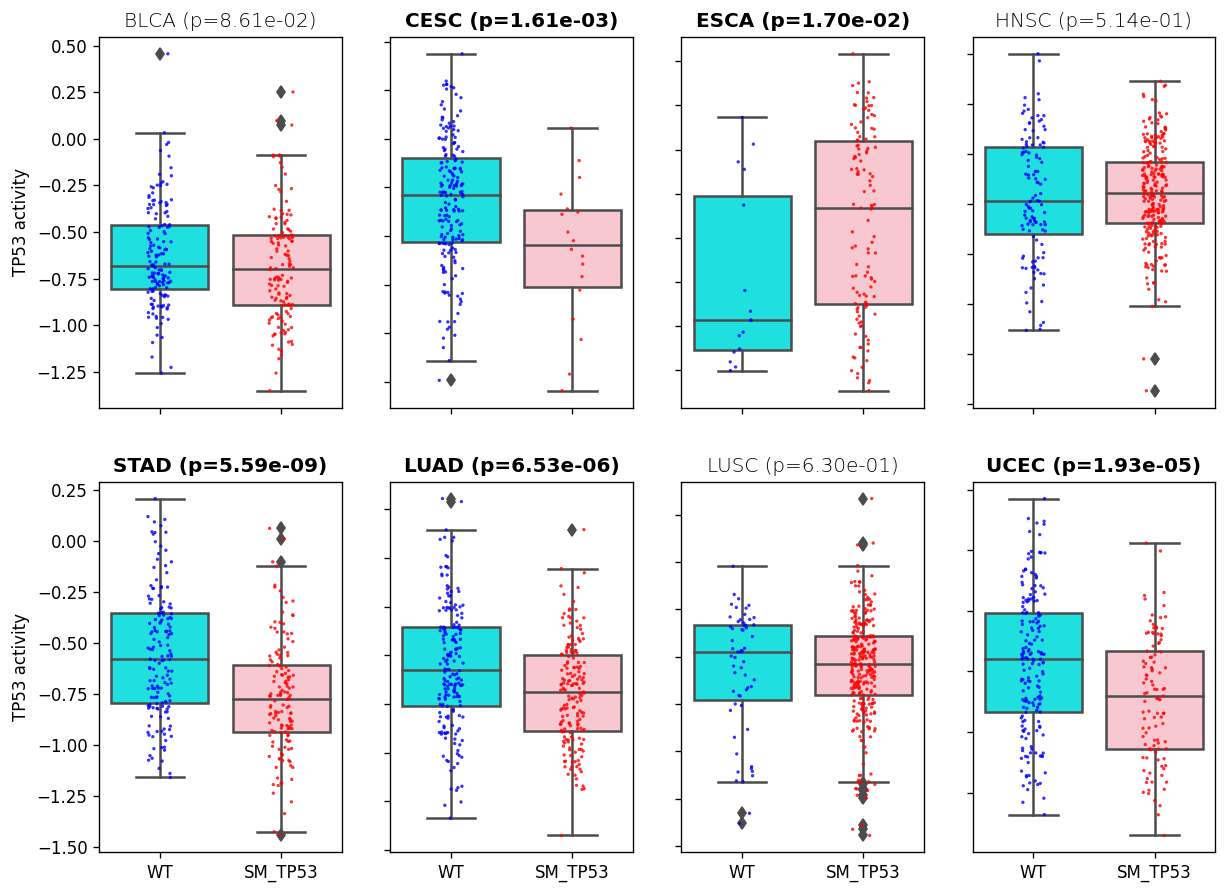

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'TP53'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()